In [2]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [21]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, batchnorm=True, last_activ=F.relu):
        super(ConvBlock, self).__init__()
        self.bn = batchnorm
        self.last_activ = last_activ
        self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
        self.b1 = nn.BatchNorm2d(out_filters)
        self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
        self.b2 = nn.BatchNorm2d(out_filters)
    def forward(self, x):
        x = self.c1(x)
        if self.bn: x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn: x = self.b2(x)
        x = self.last_activ(x)
        return x

In [5]:
class ContractiveBlock(nn.Module):
    def __init__(self, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5, batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvBlock(in_filters=in_filters, out_filters=out_filters, kernel_size=conv_kern, batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern)
        self.d1 = nn.Dropout2d(dropout)
    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))

In [6]:
class ExpansiveBlock(nn.Module):
    def __init__(self, in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvBlock(out_filters+in_filters2, out_filters, conv_kern)
        
    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin

In [7]:
class Unet(nn.Module):
    def __init__(self, n_labels, n_filters=16, p_dropout=0.5, batchnorm=True):
        super(Unet, self).__init__()
        filter_dict = {}
        filt_pair = [3, n_filters]
        
        for i in range(4):
            self.add_module('contractive_'+str(i), ContractiveBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filter_dict['contractive_'+str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2
        
        self.bottleneck = ConvBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filter_dict['bottleneck'] = (filt_pair[0], filt_pair[1])
        
        for i in reversed(range(4)):
            self.add_module('expansive_'+str(i), ExpansiveBlock(filt_pair[1], filter_dict['contractive_'+str(i)][1], filt_pair[0]))
            filter_dict['expansive_'+str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2
        
        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filter_dict['output'] = (filt_pair[1], n_labels)
        self.filter_dict = filter_dict
    
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)
        
        
        

In [18]:
net = Unet(2).cuda()

In [9]:
from PIL import Image

In [14]:
class TSegLoader(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder):
        self.images = os.listdir(image_folder)
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.tx = torchvision.transforms.Compose([
#             torchvision.transforms.Resize((256,256)),
            torchvision.transforms.ToTensor()
        ])
        
        self.mx = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
#             torchvision.transforms.Resize((256,256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x : torch.cat([x,1-x], dim=0))
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        i1 = Image.open(self.image_folder + self.images[i])
        m1 = Image.open(self.mask_folder + self.images[i])
        
        return self.tx(i1), self.mx(m1)

In [15]:
tr = torch.utils.data.DataLoader(TSegLoader('training/','manual/'), batch_size=4, shuffle=True)

In [19]:
opt = torch.optim.Adam(net.parameters())

In [20]:
loss_history = []
for i in range(32):
    train_loss = 0.0
    for x, y in tr:
        x, y = x.cuda(),y.cuda()
        opt.zero_grad()
        y_pred = net(x)
        loss = F.mse_loss(y_pred, y)
        train_loss +=loss.item()
        loss.backward()
        opt.step()   
    print (i,train_loss)
    loss_history.append(train_loss)
    pl

0 0.33820265531539917
0 0.3260776996612549
0 0.32895326614379883
0 0.31397950649261475
0 0.31196367740631104
0 0.30186137557029724
0 0.2996065616607666
0 0.3059353828430176
0 0.29343798756599426
0 0.29487013816833496
0 0.2774348556995392
0 0.2731953561306
0 0.27719447016716003
0 0.2793987989425659
0 0.2619541585445404
0 0.2729412913322449
0 0.2521534562110901
0 0.2581755518913269
0 0.25959306955337524
0 0.2468869686126709
0 0.24509364366531372
0 0.24244002997875214
0 0.2348790466785431
0 0.23833167552947998
0 0.23468759655952454
0 0.23132763803005219
0 0.22719794511795044
0 0.22156968712806702
0 0.22108957171440125
0 0.2192378044128418
0 0.218486025929451
0 0.22121432423591614
0 0.21600431203842163
0 0.20962435007095337
0 0.21125641465187073
0 0.21110376715660095
0 0.2053271234035492
0 0.20984286069869995
0 0.21077951788902283
0 0.20097729563713074
0 0.20434971153736115
0 0.20143842697143555
0 0.19728180766105652
0 0.19667473435401917
0 0.19251322746276855
0 0.19876080751419067
0 0.204

0 0.05866708233952522
0 0.0539722740650177
0 0.05206744000315666
0 0.04876791313290596
0 0.05196305736899376
0 0.05082597956061363
0 0.045165054500103
0 0.0417940653860569
0 0.05132218077778816
0 0.06098705157637596
0 0.04764331877231598
0 0.04881531745195389
0 0.055412083864212036
0 0.04779661446809769
0 0.04268813133239746
0 0.055280450731515884
0 0.05017177015542984
0 0.047351233661174774
0 0.043401576578617096
0 0.046655844897031784
0 0.049810878932476044
0 0.04821498692035675
0 0.0746150016784668
0 0.0581388995051384
0 0.049684442579746246
0 0.04734101891517639
0 0.048489831387996674
0 0.04340200871229172
0 0.04605453088879585
0 0.04623778536915779
0 0.05755896121263504
0 0.061950523406267166
0 0.04998944699764252
0 0.044599972665309906
0 0.04436572641134262
0 0.05288156121969223
0 0.07151633501052856
0 0.05050619691610336
0 0.04414737597107887
0 0.049654219299554825
0 0.04455999657511711
0 0.048120103776454926
0 0.05241663381457329
0 0.05464690923690796
0 0.05591753125190735
0 0.

1 0.04178429767489433
1 0.04471465200185776
1 0.04236111417412758
1 0.03977639600634575
1 0.04816330224275589
1 0.043168872594833374
1 0.04716508835554123
1 0.04341597110033035
1 0.042396627366542816
1 0.040613096207380295
1 0.04065074771642685
1 0.045658160001039505
1 0.03360776975750923
1 0.040749527513980865
1 0.047371648252010345
1 0.03533526510000229
1 0.039077792316675186
1 0.04626622423529625
1 0.03677365928888321
1 0.04358915239572525
1 0.04146174341440201
1 0.04062427207827568
1 0.04466986656188965
1 0.04664221405982971
1 0.04774325340986252
1 0.05571550875902176
1 0.036273371428251266
1 0.04146632179617882
1 0.042353756725788116
1 0.049494192004203796
1 0.04586601257324219
1 0.049186110496520996
1 0.04715888947248459
1 0.038579680025577545
1 0.036627594381570816
1 0.04791020601987839
1 0.039932772517204285
1 0.04452652856707573
1 0.03947103023529053
1 0.045078471302986145
1 0.03933633863925934
1 0.03417670726776123
1 0.036473680287599564
1 0.0458625927567482
1 0.0401867441833

2 0.0493311733007431
2 0.052257515490055084
2 0.04591307044029236
2 0.03715653717517853
2 0.03698364645242691
2 0.03215833008289337
2 0.04031345993280411
2 0.044132672250270844
2 0.035072583705186844
2 0.03642435371875763
2 0.04128745570778847
2 0.0478014200925827
2 0.04501693695783615
2 0.04919128865003586
2 0.04092275723814964
2 0.04026966914534569
2 0.039958443492650986
2 0.034247975796461105
2 0.04088401049375534
2 0.03901604190468788
2 0.038261931389570236
2 0.034539081156253815
2 0.04610390216112137
2 0.039564575999975204
2 0.0465427041053772
2 0.03761966526508331
2 0.041507720947265625
2 0.042097169905900955
2 0.034948986023664474
2 0.034225523471832275
2 0.03509066253900528
2 0.03405732288956642
2 0.031030802056193352
2 0.03519444167613983
2 0.02900414541363716
2 0.03846445679664612
2 0.038224391639232635
2 0.03679110109806061
2 0.057301800698041916
2 0.04579178988933563
2 0.04136555641889572
2 0.04992694407701492
2 0.035268448293209076
2 0.038728438317775726
2 0.04092923924326

2 0.034451697021722794
2 0.029722178354859352
2 0.034803904592990875
2 0.04213361069560051
2 0.04097800701856613
2 0.03481387719511986
2 0.03199172765016556
2 0.04494673013687134
2 0.033422425389289856
2 0.038939040154218674
2 0.035664886236190796
2 0.036814264953136444
2 0.03391575068235397
2 0.03203577175736427
2 0.03925865888595581
2 0.03573163226246834
3 0.041894473135471344
3 0.04424426332116127
3 0.033633820712566376
3 0.03364576771855354
3 0.037809766829013824
3 0.04347897320985794
3 0.032269708812236786
3 0.041977424174547195
3 0.04068450629711151
3 0.033182885497808456
3 0.04335992783308029
3 0.05481269210577011
3 0.03756378963589668
3 0.036063943058252335
3 0.034210704267024994
3 0.03572631627321243
3 0.03683660551905632
3 0.0412132553756237
3 0.03792739659547806
3 0.04217374324798584
3 0.03202911093831062
3 0.03476090729236603
3 0.036752961575984955
3 0.037213437259197235
3 0.03369763121008873
3 0.03825729340314865
3 0.04628726467490196
3 0.03594963252544403
3 0.033538594841

3 0.029069121927022934
3 0.04046764597296715
3 0.03861314430832863
3 0.04167113080620766
3 0.030627716332674026
3 0.03231169655919075
3 0.041218966245651245
3 0.0351460725069046
3 0.032701749354600906
3 0.029344990849494934
3 0.035188332200050354
3 0.03500213846564293
3 0.0396384671330452
3 0.03311614692211151
3 0.037325773388147354
3 0.03440280258655548
3 0.05067657306790352
3 0.034206945449113846
3 0.035733193159103394
3 0.03603188320994377
3 0.032384201884269714
3 0.049537062644958496
3 0.03506091237068176
3 0.03420010954141617
3 0.035982295870780945
3 0.03864124044775963
3 0.03632740303874016
3 0.042408257722854614
3 0.03517918661236763
3 0.037679947912693024
3 0.046736981719732285
3 0.03560839220881462
3 0.040464382618665695
3 0.03239043056964874
3 0.037677884101867676
3 0.035817790776491165
3 0.04806237667798996
3 0.03474140539765358
3 0.04546656832098961
3 0.04366306588053703
3 0.03407938405871391
3 0.03723710775375366
3 0.03317590430378914
3 0.030449669808149338
3 0.03339269384

4 0.03436748683452606
4 0.04392372816801071
4 0.030931059271097183
4 0.04249141365289688
4 0.0340137742459774
4 0.040888458490371704
4 0.04624533653259277
4 0.032723747193813324
4 0.03834845870733261
4 0.041193507611751556
4 0.0374617725610733
4 0.03688785806298256
4 0.036101408302783966
4 0.0374898687005043
4 0.029972108080983162
4 0.04071759432554245
4 0.030310997739434242
4 0.027556749060750008
4 0.03367079794406891
4 0.04050898551940918
4 0.03166929632425308
4 0.03549632057547569
4 0.03427325189113617
4 0.04255562648177147
4 0.05097151920199394
4 0.03153830021619797
4 0.02708328142762184
4 0.03434673696756363
4 0.03415433317422867
4 0.03878293186426163
4 0.03139450028538704
4 0.04657961428165436
4 0.03585274890065193
4 0.029920518398284912
4 0.03517743945121765
4 0.039086394011974335
4 0.034008461982011795
4 0.03644957393407822
4 0.04078447446227074
4 0.03801427781581879
4 0.028111524879932404
4 0.029446879401803017
4 0.032814495265483856
4 0.032764073461294174
4 0.0390158779919147

5 0.03502405434846878
5 0.030229602009058
5 0.03412843495607376
5 0.037066586315631866
5 0.03378138691186905
5 0.031119879335165024
5 0.04024725407361984
5 0.03343639522790909
5 0.0412922129034996
5 0.03224501013755798
5 0.030097106471657753
5 0.03273189812898636
5 0.03235350549221039
5 0.04308942332863808
5 0.03843129798769951
5 0.03574802353978157
5 0.034434907138347626
5 0.04809405654668808
5 0.03894897550344467
5 0.04335413873195648
5 0.04251836612820625
5 0.034235551953315735
5 0.034349530935287476
5 0.03644537553191185
5 0.03160857409238815
5 0.0372777134180069
5 0.03600231185555458
5 0.03819768875837326
5 0.03690347075462341
5 0.038165584206581116
5 0.039798323065042496
5 0.03532785177230835
5 0.059913843870162964
5 0.02972838282585144
5 0.03672746196389198
5 0.032557565718889236
5 0.037825554609298706
5 0.040850650519132614
5 0.033357299864292145
5 0.030310552567243576
5 0.03487961366772652
5 0.03322659432888031
5 0.035242266952991486
5 0.03716288506984711
5 0.03255917131900787

5 0.03242480382323265
5 0.034278299659490585
5 0.04870104044675827
5 0.035837702453136444
5 0.032727256417274475
5 0.036114055663347244
5 0.033665724098682404
5 0.029889313504099846
5 0.04065936431288719
5 0.043192267417907715
5 0.04150231182575226
5 0.03447901830077171
5 0.04696110263466835
5 0.0430380254983902
5 0.03140578046441078
5 0.03284440562129021
5 0.03260594233870506
5 0.03871716186404228
5 0.03601602092385292
5 0.027840323746204376
5 0.03397807478904724
5 0.030157174915075302
5 0.03829331696033478
5 0.031146954745054245
5 0.02974514476954937
5 0.030769838020205498
5 0.035765860229730606
5 0.043796174228191376
5 0.030689632520079613
5 0.047249507158994675
5 0.04270036891102791
5 0.03574180603027344
5 0.04179304465651512
5 0.034266892820596695
5 0.036258067935705185
5 0.03738611936569214
5 0.036354709416627884
5 0.03709735721349716
5 0.03255701810121536
5 0.030497809872031212
6 0.0383664146065712
6 0.030267085880041122
6 0.035866379737854004
6 0.0353442057967186
6 0.0500280186

6 0.03321314603090286
6 0.028374286368489265
6 0.04560069367289543
6 0.049594927579164505
6 0.03703036904335022
6 0.030349142849445343
6 0.03243905305862427
6 0.03765038400888443
6 0.03189774975180626
6 0.03619997203350067
6 0.03301972895860672
6 0.04102932661771774
6 0.03396645560860634
6 0.03296835720539093
6 0.040040165185928345
6 0.04173099622130394
6 0.03089473769068718
6 0.03169230371713638
6 0.0289103202521801
6 0.03610804304480553
6 0.03445327281951904
6 0.031822700053453445
6 0.03178352862596512
6 0.042424723505973816
6 0.037149179726839066
6 0.04029957950115204
6 0.03041864186525345
6 0.03044440597295761
6 0.03012450784444809
6 0.03474186360836029
6 0.028795789927244186
6 0.032135941088199615
6 0.038865141570568085
6 0.02776734158396721
6 0.041030965745449066
6 0.03486451879143715
6 0.030636437237262726
6 0.028586965054273605
6 0.052420973777770996
6 0.03338976204395294
6 0.02981298230588436
6 0.03640235215425491
6 0.04051697254180908
6 0.03258884698152542
6 0.046421028673648

7 0.028745580464601517
7 0.029429925605654716
7 0.03243482485413551
7 0.030128076672554016
7 0.029144585132598877
7 0.03281372785568237
7 0.029418963938951492
7 0.03251190483570099
7 0.039537616074085236
7 0.02983071096241474
7 0.034229572862386703
7 0.03080700896680355
7 0.03295714780688286
7 0.03301800787448883
7 0.04116936773061752
7 0.03509810194373131
7 0.042189717292785645
7 0.03781035542488098
7 0.02958517335355282
7 0.02657599002122879
7 0.037827178835868835
7 0.029176024720072746
7 0.03481133282184601
7 0.03153982013463974
7 0.029719127342104912
7 0.039938658475875854
7 0.038065604865550995
7 0.03773551806807518
7 0.03489353880286217
7 0.04263871908187866
7 0.03385970741510391
7 0.03260228782892227
7 0.029322918504476547
7 0.03673093393445015
7 0.03653620183467865
7 0.035225722938776016
7 0.036440905183553696
7 0.042313724756240845
7 0.03070058673620224
7 0.0405169241130352
7 0.0320134162902832
7 0.03283895552158356
7 0.03201325610280037
7 0.04211699962615967
7 0.0330833196640

8 0.030585799366235733
8 0.040020160377025604
8 0.02980516105890274
8 0.03755364567041397
8 0.02834302932024002
8 0.03744686394929886
8 0.030859773978590965
8 0.03809572756290436
8 0.03210854157805443
8 0.04054262116551399
8 0.03565602004528046
8 0.03041667863726616
8 0.04836466535925865
8 0.03331208974123001
8 0.033344853669404984
8 0.036196134984493256
8 0.03388146683573723
8 0.034774962812662125
8 0.028990458697080612
8 0.036242011934518814
8 0.04017946869134903
8 0.03546803817152977
8 0.031606484204530716
8 0.03195074945688248
8 0.02922907844185829
8 0.036269284784793854
8 0.03345111012458801
8 0.029164955019950867
8 0.029971063137054443
8 0.02837875485420227
8 0.03099016845226288
8 0.03922172635793686
8 0.032262690365314484
8 0.036505211144685745
8 0.031921837478876114
8 0.03380173444747925
8 0.03072793409228325
8 0.034096136689186096
8 0.033944591879844666
8 0.03578086942434311
8 0.03755533695220947
8 0.028367972001433372
8 0.03390931710600853
8 0.031185824424028397
8 0.035010948

KeyboardInterrupt: 

In [22]:
torch.save(net, 'test.pth')

/home/chironx/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Unet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/chironx/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ContractiveBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/chironx/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/chironx/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ExpansiveBlock. It won't be checked for correctness upon loading.
  "type " + o

In [23]:
net.filter_dict

{'contractive_0': (3, 16),
 'contractive_1': (16, 32),
 'contractive_2': (32, 64),
 'contractive_3': (64, 128),
 'bottleneck': (128, 256),
 'expansive_3': (256, 128),
 'expansive_2': (128, 64),
 'expansive_1': (64, 32),
 'expansive_0': (32, 16),
 'output': (16, 2)}

In [52]:
im = Image.open('training/1203.jpg')

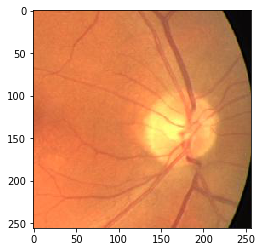

In [53]:
plt.imshow(im)

In [58]:
data_tranform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
s = data_tranform(im)

In [59]:
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

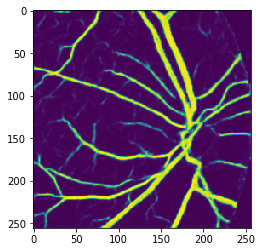

In [60]:
plt.imshow(pred[0][0])

In [84]:
im = Image.open('diabetic-retinopathy-header.jpg')
im = np.asarray(im)
im = im[200:456,400:656]

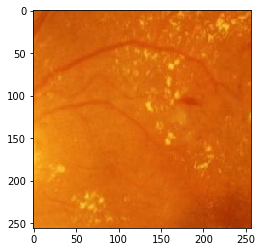

In [85]:
im.shape
plt.imshow(im)

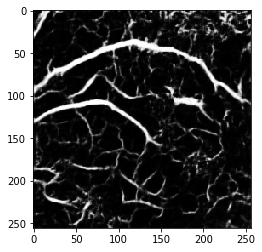

In [98]:
data_tranform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()
plt.imshow(pred[0][0],cmap='gray')

In [110]:
def f(x):
    if x>0.8:
        return 1.
    else:
        return 0.
f = np.vectorize(f)

In [111]:
pred_cure = f(pred[0][0])

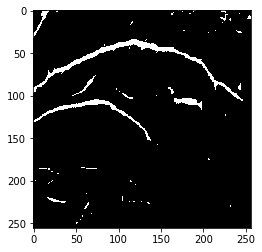

In [112]:
plt.imshow(pred_cure,cmap='gray')